In [155]:
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import xml.etree.ElementTree as ET
%matplotlib inline
num_cpu = 64
clientCPU = range(0,16)
serverCPU = range(16,24)
idle_times={}
for i in range(num_cpu):
    idle_times[i]=[]
    
outputfolder = "13_aug_test/ARM_15m_3500_40gb"
outputfolder = "output_arm"
utilFile = outputfolder+"/util.txt"
operationsFile = outputfolder+"/operations.txt"
benchmarkFile = outputfolder+"/benchmark.txt"
with open(utilFile) as f:
    utilBigList = f.read().split("@")[1:]

for utilSingle in utilBigList:
    idle_times_temp = {}
    for i in range(num_cpu):
        idle_times_temp[i]=[]
    stringNewLine = utilSingle.split('\n')[2:]
    for stringLine in stringNewLine:        
        words = stringLine.split()
        if(len(words)>=2 and words[1].isdigit()):
            CPU = int(words[1])
            idle = float(words[-1].rstrip('\x00'))
            idle_times_temp[CPU].append(idle)
    for i in range(num_cpu):
        idle_times[i].append(idle_times_temp[i])
idle_times_avg = {}
for i in range(num_cpu):
    idle_times_avg[i]=[]
    for times in idle_times[i]:
        idle_times_avg[i].append(np.mean(times))
#print(idle_times_avg)

with open(operationsFile) as f:                                                                                                                                                                                     
    operationsStr = f.read().split('\n')[:-1]
operations = np.array(map(int, operationsStr))
def show(elem):
    print elem.tag
    for child in elem.findall('*'):
        show(child)
def readBenchmark(benchmarkFile):
    xmlList = []
    start = 0
    with open(benchmarkFile) as f:
        content = f.read()
        while(True):
            a = ( string.find(content,"<benchResults>"))
            
            b = ( string.find(content[start:],"</benchResults>")) + len("</benchResults>")

            if (a is not -1 and b is not -1):
                xmlList.append(content[a:b])
                content = content[b:]
            else:
                break
    avg = []
    p90th = []
    p99th = []
    totalOps = []
    throughput = []
    for xml in xmlList:
        benchResult = ET.fromstring(xml)
        driverSummary = benchResult.find("driverSummary")
        avg.append(float(driverSummary.find("responseTimes/operation/avg").text))
        p90th.append(float(driverSummary.find("responseTimes/operation/p90th").text.replace('>','')))
        p99th.append(float(driverSummary.find("responseTimes/operation/p99th").text.replace('>','')))
        totalOps.append(float(driverSummary.find("totalOps").text))
        throughput.append(float(driverSummary.find("metric").text))
    return {
        "avg":avg,
        "p90th":p90th,
        "p99th":p99th,
        "totalOps":totalOps,
        "throughput":throughput
    }
    

    
    
    
    
    
    
    


results = readBenchmark(benchmarkFile)
for result in results:
    print("{}:{}".format(result,results[result]))
for cpu in idle_times_avg:
    idle_times_avg[cpu] = np.array(idle_times_avg[cpu])
# idle_times_avg = np.array(idle_times_avg)?
# print(idle_times_avg[0])
   




p90th:[0.225, 2.475, 2.475, 0.108, 2.475, 0.113, 0.113, 0.138, 2.475, 2.475, 0.145, 0.105, 0.103, 0.12, 0.705, 0.113, 0.105, 2.475, 2.475]
avg:[0.089, 1.889, 2.113, 0.044, 1.034, 0.046, 0.044, 0.057, 1.875, 1.935, 0.059, 0.044, 0.041, 0.048, 0.245, 0.046, 0.042, 1.532, 1.022]
throughput:[161.867, 156.7, 164.867, 81.967, 171.267, 96.367, 11.1, 140.233, 165.8, 168.6, 151.4, 30.0, 38.6, 110.0, 177.967, 102.867, 61.9, 171.467, 174.333]
totalOps:[4856.0, 4701.0, 4946.0, 2459.0, 5138.0, 2891.0, 333.0, 4207.0, 4974.0, 5058.0, 4542.0, 900.0, 1158.0, 3300.0, 5339.0, 3086.0, 1857.0, 5144.0, 5230.0]
p99th:[0.628, 2.475, 2.475, 0.218, 2.475, 0.203, 0.18, 0.31, 2.475, 2.475, 0.32, 0.198, 0.195, 0.23, 1.625, 0.22, 0.21, 2.475, 2.475]


In [156]:
bench1 = readBenchmark(benchmarkFile)
#bench1 = readBenchmark("output/benchmark2.txt")
for i in idle_times_avg:
    idle_times_avg[i]=idle_times_avg[i][0:len(bench1["throughput"])]
operations = operations[:len(bench1["throughput"])]
util_bench = idle_times_avg[0]*0
util_server = idle_times_avg[0]*0
for i in range(num_cpu):
    if i in clientCPU:
        util_bench = util_bench + idle_times_avg[i]
    elif i in serverCPU:
        util_server = util_server + idle_times_avg[i]
util_bench = 100.0 - util_bench/len(clientCPU)
util_server = 100.0 - util_server/(len(serverCPU))
bench1["CPUUtilClient"] = util_bench
bench1["CPUUtilServer"] = util_server
# readLatency = bench1["readLatency"]
# plt.figure(1)

# for i in range(num_cpu):
#     if(i in clientCPU):
#         plt.plot(operations,100-np.array(idle_times_avg[i]),label=i,color='red')
#         continue
#     elif(i in serverCPU):
#         plt.plot(operations,100-np.array(idle_times_avg[i]),label=i,color='blue')
# plt.legend()
# plt.xlabel("Operations")
# plt.ylabel("CPU Util (%)")
# plt.show()

# plt.figure(2)
# plt.plot(operations,util_bench,label="client")
# plt.plot(operations,util_server,label="server")
# plt.legend()
# plt.xlabel("Operations")
# plt.ylabel("CPU Util (%)")
# plt.savefig("util.png")
# plt.show()

# plt.figure(2)
# plt.plot(bench1["throughput"],util_bench,label="client")
# plt.plot(bench1["throughput"],util_server,label="server")
# plt.legend()
# plt.xlabel("Throughput (op/s)")
# plt.ylabel("CPU Util (%)")
# plt.show()

# plt.figure(3)
# plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["updateLatency95"],label="Update Latency95")
# plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["readLatency95"],label="Read Latency95")
# plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["updateLatency99"],label="Update Latency99")
# plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["readLatency99"],label="Read Latency99")
# # plt.ylim(ymax=10000)
# plt.legend()
# plt.xlabel("Operations")
# plt.ylabel("Latency (us)")
# plt.savefig("latency.png")
# plt.show()


# plt.figure(3)
# plt.plot(bench1["throughput"],bench1["updateLatency95"],label="Update Latency95")
# plt.plot(bench1["throughput"],bench1["readLatency95"],label="Read Latency95")
# plt.plot(bench1["throughput"],bench1["updateLatency99"],label="Update Latency99")
# plt.plot(bench1["throughput"],bench1["readLatency99"],label="Read Latency99")
# # plt.ylim(ymax=10000)
# plt.legend()
# plt.xlabel("Throughput(op/s)")
# plt.ylabel("Latency (us)")
# plt.savefig("throughput.png")
# plt.show()

# plt.figure()
# plt.plot(operations[0:len(bench1["throughput"])],bench1["throughput"])
# plt.xlabel("operations")
# plt.ylabel("Throughput (op/s)")
# # plt.savefig("throughput.png")
# plt.show()

# # plt.figure(4)
# # plt.plot(bench1["throughput"],bench1["updateLatency95"],label="Update Latency95")
# # plt.plot(bench1["throughput"],bench1["readLatency95"],label="Read Latency95")
# # plt.plot(bench1["throughput"],bench1["updateLatency99"],label="Update Latency99")
# # plt.plot(bench1["throughput"],bench1["readLatency99"],label="Read Latency99")

# # plt.legend()
# # plt.show()


# # plt.figure(4)
# # plt.plot(operations[:len(readOperations)],np.array(operations[:len(readOperations)])-(np.array(readOperations)+np.array(updateOperations)))
# # plt.show()
# fig = plt.figure()
# (a,b) = fig.get_size_inches()
# plt.figure(figsize=(a, b*3))
# plt.subplot(3,1,1)
# plt.plot(operations,util_bench,label="client")
# plt.plot(operations,util_server,label="server")
# plt.legend()
# plt.xlabel("Operations")
# plt.ylabel("CPU Util (%)")
# plt.savefig("util.png")
# # plt.show()


# plt.subplot(3,1,2)
# plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["updateLatency95"],label="Update Latency95")
# plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["readLatency95"],label="Read Latency95")
# plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["updateLatency99"],label="Update Latency99")
# plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["readLatency99"],label="Read Latency99")
# # plt.ylim(ymax=10000)
# plt.legend()
# plt.xlabel("Operations")
# plt.ylabel("Latency (us)")
# # plt.savefig("latency.png")
# # plt.show()

# plt.subplot(3,1,3)
# plt.plot(operations[0:len(bench1["throughput"])],bench1["throughput"])
# plt.xlabel("operations")
# plt.ylabel("Throughput (op/s)")
# plt.savefig("graphs.png")
# plt.show()

In [157]:
values = ["avg","p90th","p99th","totalOps","throughput","CPUUtilClient","CPUUtilServer"]
benchStdMean = {}
for value in values:
    benchStdMean[value] = []
operations = operations[0:len(bench1["avg"])]

unique_op={}
for i in range(len(operations)):
    if operations[i] not in unique_op:
        unique_op[operations[i]] = operations[i]
sorted_op = np.sort(unique_op.keys())
for op in sorted_op:
    ii = np.where(operations == op)[0]
    for value in values:
        benchStdMean[value].append(np.take(bench1[value],ii))
for value in values:
    benchStdMean[value+"Mean"] = []
    for x in benchStdMean[value]:
        benchStdMean[value+"Mean"].append(np.mean(x)) 
    benchStdMean[value+"Std"] = []
    for x in benchStdMean[value]:
        benchStdMean[value+"Std"].append(np.std(x)) 
for value in benchStdMean:
    benchStdMean[value]=np.array(benchStdMean[value])

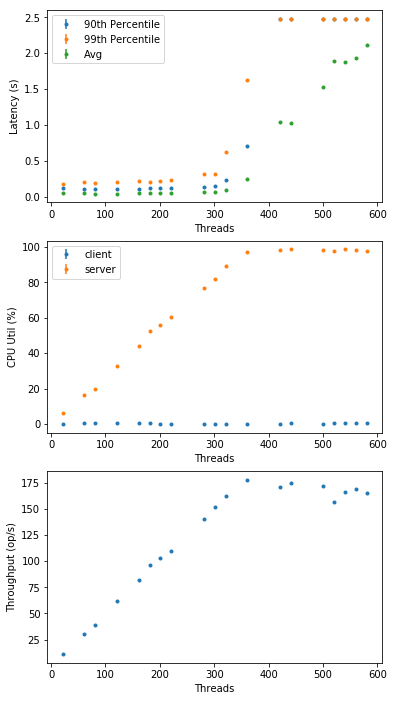

In [158]:

fig = plt.figure()
(a,b) = fig.get_size_inches()
plt.figure(figsize=(a, b*3))


plt.subplot(3,1,1)
plt.errorbar(sorted_op,benchStdMean["p90thMean"],yerr = benchStdMean["p90thStd"],label="90th Percentile",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["p99thMean"],yerr = benchStdMean["p99thStd"],label="99th Percentile",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["avgMean"],yerr = benchStdMean["avgStd"],label="Avg",linestyle='None',marker=".")
# plt.plot(sorted_op,sorted_op*0+0.2,linestyle="")
# plt.plot(operations[0:len(bench1["p99th"])],bench1["p99th"],label="Update Latency99",linestyle='None',marker=".")
# plt.plot(operations[0:len(bench1["p99th"])],bench1["avg"],label="Update LatencyAvg",linestyle='None',marker=".")
plt.xlabel("Threads")
plt.ylabel("Latency (s)")
plt.legend()


# plt.subplot(4,1,2)
# plt.errorbar(sorted_op,benchStdMean["readLatency95Mean"],yerr = benchStdMean["readLatency95Std"],label="Read Latency95",linestyle='None',marker=".")
# plt.errorbar(sorted_op,benchStdMean["readLatency99Mean"],yerr = benchStdMean["readLatency99Std"],label="read Latency99",linestyle='None',marker=".")
# plt.errorbar(sorted_op,benchStdMean["readLatencyAvgMean"],yerr = benchStdMean["readLatencyAvgStd"],label="read LatencyAvg",linestyle='None',marker=".")
# plt.xlabel("Target (Operations/sec)")
# plt.ylabel("Latency (ms)")
# plt.legend()



plt.subplot(3,1,3)
plt.errorbar(sorted_op,benchStdMean["throughputMean"],yerr = benchStdMean["throughputStd"],label="Throughput",linestyle='None',marker=".")
plt.xlabel("Threads")
plt.ylabel("Throughput (op/s)")


plt.subplot(3,1,2)
plt.errorbar(sorted_op,benchStdMean["CPUUtilClientMean"],yerr = benchStdMean["CPUUtilClientStd"],label="client",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["CPUUtilServerMean"],yerr = benchStdMean["CPUUtilServerStd"],label="server",linestyle='None',marker=".")
plt.legend()
plt.xlabel("Threads")
plt.ylabel("CPU Util (%)")
plt.savefig(outputfolder + ".png")
plt.savefig("Web_search_result.png")
plt.show()

# plt.figure(1)
# plt.errorbar(sorted_op,benchStdMean["runTimeMean"],yerr = benchStdMean["runTimeStd"],linestyle='None',marker=".")
# plt.xlabel("Target (op/s)")
# plt.ylabel("Time (ms)")
# plt.show()




In [159]:
print(sorted_op)
benchStdMean["p90th"]
# benchStdMean["p90thStd"]

[ 21  61  81 121 161 181 201 221 281 301 321 361 421 441 501 521 541 561
 581]


array([[ 0.113],
       [ 0.105],
       [ 0.103],
       [ 0.105],
       [ 0.108],
       [ 0.113],
       [ 0.113],
       [ 0.12 ],
       [ 0.138],
       [ 0.145],
       [ 0.225],
       [ 0.705],
       [ 2.475],
       [ 2.475],
       [ 2.475],
       [ 2.475],
       [ 2.475],
       [ 2.475],
       [ 2.475]])

In [127]:
benchStdMean["readLatency99Mean"]
for i in range(len(sorted_op)):
    print("{}:{}".format(sorted_op[i],benchStdMean["readLatency99Mean"][i]/benchStdMean["updateLatency99Mean"][i]))
print("Avg")
for i in range(len(sorted_op)):
    print("{}:{}".format(sorted_op[i],benchStdMean["readLatencyAvgMean"][i]/benchStdMean["updateLatencyAvgMean"][i]))    


KeyError: 'readLatency99Mean'

In [ ]:
benchStdMean["updateLatency95Mean"]